In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os



In [ ]:
data_folder = '../data/example'
output_folder = '../output'

os.makedirs(output_folder, exist_ok=True)

record_length = 1024  # Number of samples per waveform
sampling_rate = 5e9  # 5 GHz
time_per_sample = 1 / sampling_rate  # Time per sample in seconds
max_samples = 1e3

In [ ]:
def ProcessFilePython(filename, max_chunks=10000, keep_waveforms=False):
    """Process waveform data from a text file.
    Args:
        max_chunks (int): Maximum number of waveform chunks to process.
        keep_waveforms (bool): Keep full waveform data in output as array, costly in storage.
    Returns:
        list of dict: Processed waveform data with keys 'Channel', 'PosX', 'PosY', 'Height', 'Time', and optionally 'Waveform'.
    """

    if keep_waveforms and max_chunks > 1000:
        print("Warning: Keeping waveforms with a high number of chunks may consume significant memory. Consider reducing max_chunks or setting keep_waveforms to False.")
    
    # Parse filename for position and channel info (if needed)
    rFname = filename.split("/")[-1]
    try:
        posX = float(rFname.split('pos_')[-1].split("_")[0])
        posY = float(rFname.split('pos_')[-1].split("_")[1])
        ch = int(rFname.split('pos_')[-1].split("_")[-1].split(".")[0])
    except (IndexError, ValueError):
        ch = rFname.split('_')[-1].split(".")[0]
        posX, posY = None, None

    # Read file into numpy array, skipping first 8 lines
    try:
        data = np.loadtxt(filename, skiprows=8)
    except ValueError:
        # Fallback: ignore bad lines
        data = np.genfromtxt(filename, skip_header=8, invalid_raise=False)
    
    # Process in 1024-sample chunks
    n_chunks = min(len(data) // 1024, max_chunks)
    rtn = []

    for i in range(n_chunks):
        pulse = data[i*1024:(i+1)*1024].copy() # Copy to avoid modifying original data

        # Baseline correction
        mn1 = np.mean(pulse[:5])
        mn2 = np.mean(pulse[-35:-30])
        mn = min(mn1, mn2) # whichever is lower 
        pulse = np.abs(pulse - mn)
        pulse = pulse[:-30]  # Ignore last 30 samples

        # Threshold detection
        threshold = 0.5 * np.max(pulse[:-30])
        above = pulse > threshold
        crossings = np.where(np.diff(above.astype(int)) > 0)[0]
        if len(crossings) == 0:
            t = 0
        else:
            t = crossings[0]

        # Interpolate 0.8*max after sample 100
        peak_val = 0.8 * np.max(pulse[100:])
        if pulse[t+1] != pulse[t]:
            time_f = t + (peak_val - pulse[t]) / (pulse[t+1] - pulse[t])
        else:
            time_f = t

        if keep_waveforms:
            rtn.append({
                'Channel': ch,
                'PosX': posX,
                'PosY': posY,
                'Height': np.max(pulse),
                'Time': time_f,
                'Waveform': pulse
            })

        else:
            rtn.append({
                'Channel': ch,
                'PosX': posX,
                'PosY': posY,
                'Height': np.max(pulse),
                'Time': time_f
            })

    return rtn






Processing channel 0
Processing channel 1
Processing channel 2


In [20]:
channel = 0
print(f"Processing channel {channel}")
file = os.path.join(data_folder, f'wave_{channel}.txt')
results = ProcessFilePython(file, max_chunks=100, keep_waveforms=True)
df = pd.DataFrame(results)

Processing channel 0


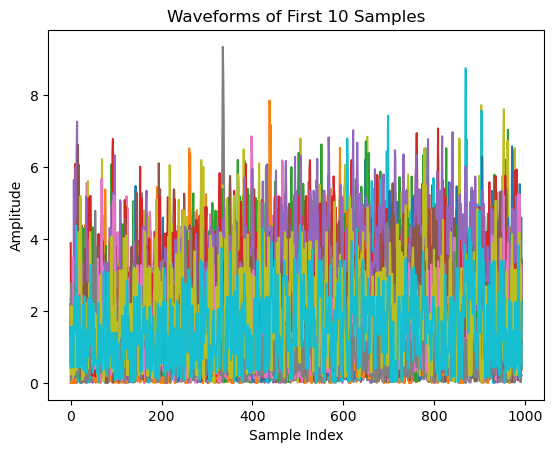

In [5]:
for i in range(20):
    plt.plot(df['Waveform'].iloc[i])
plt.title('Waveforms of First 10 Samples')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

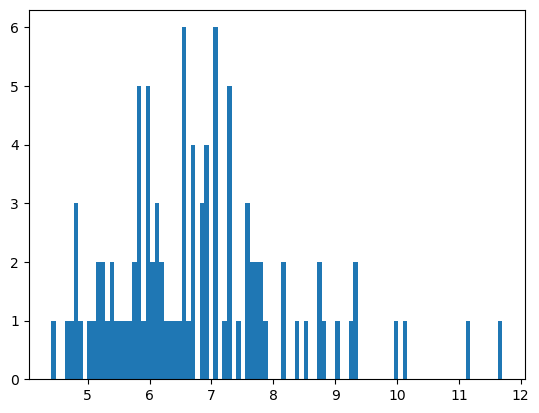

(array([22., 38., 20.,  4.,  3.,  4.,  4.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.37095758,   7.44775358,  13.52454959,  19.6013456 ,
         25.6781416 ,  31.75493761,  37.83173362,  43.90852962,
         49.98532563,  56.06212163,  62.13891764,  68.21571365,
         74.29250965,  80.36930566,  86.44610167,  92.52289767,
         98.59969368, 104.67648969, 110.75328569, 116.8300817 ,
        122.90687771, 128.98367371, 135.06046972, 141.13726573,
        147.21406173, 153.29085774, 159.36765374, 

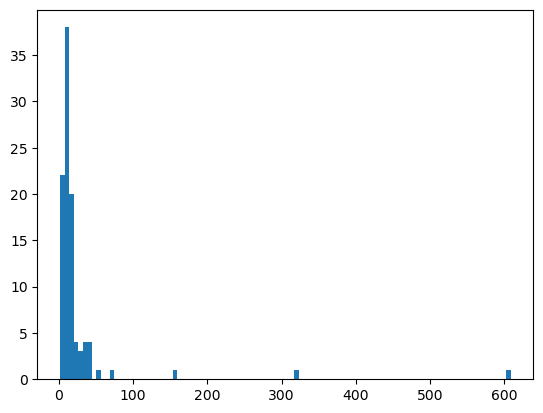

In [6]:
plt.hist(df['Height'], bins=100)
plt.show()
plt.hist(df['Time'], bins=100)

In [7]:
# import seaborn as sns

# plt.rcParams['figure.figsize'] = [40, 8]
# fig, axs = plt.subplots(ncols=4)

# df2 = df[['X', 'Y', 'Height']][df['Channel']==0].copy()
# df2['Height'] = pd.to_numeric(df2['Height']/np.max(df2['Height']))
# pivotted= df2.pivot(index = 'Y',columns = 'X',values='Height')
# sns.heatmap(pivotted,cmap='RdBu',  ax=axs[0]).set_title("Channel 0")

# df2 = df[['X', 'Y', 'Height']][df['Channel']==1].copy()
# df2['Height'] = pd.to_numeric(df2['Height']/np.max(df2['Height']))
# pivotted= df2.pivot(index = 'Y',columns = 'X',values='Height')
# sns.heatmap(pivotted,cmap='RdBu',  ax=axs[1]).set_title("Channel 1")

# df2 = df[['X', 'Y', 'Height']][df['Channel']==2].copy()
# df2['Height'] = pd.to_numeric(df2['Height']/np.max(df2['Height']))
# pivotted= df2.pivot(index = 'Y',columns = 'X',values='Height')
# sns.heatmap(pivotted,cmap='RdBu',  ax=axs[2]).set_title("Channel 2")

# df2 = df[['X', 'Y', 'Height']][df['Channel']==3].copy()
# df2['Height'] = pd.to_numeric(df2['Height']/np.max(df2['Height']))
# pivotted= df2.pivot(index = 'Y',columns = 'X',values='Height')
# sns.heatmap(pivotted,cmap='RdBu',  ax=axs[3]).set_title("Channel 3")